In [2]:
import torch 
import numpy as np 
import os
import re 
import random 

import seaborn as sns
import matplotlib.pyplot as plt 

from transformers import AutoTokenizer
from torch.utils.data import Dataset 
from data import TranscriptDataset

In [3]:
ts = TranscriptDataset(tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased'),
                                                               overwrite=False)

<Axes: ylabel='Count'>

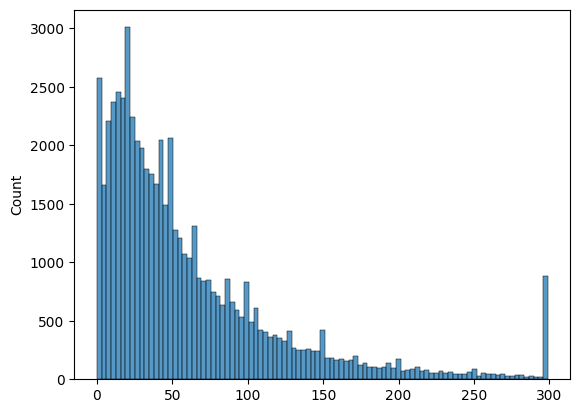

In [3]:
# Length of two context windows for input
sns.histplot(data=[len(t['input']['input_ids']) for t in ts])

In [15]:
def first_turn_token(t):
    idx = (t['output']['input_ids'] == 102).nonzero(as_tuple=True)[0]
    if len(idx) < 1:
        return 101 
    return idx[0].item()

In [16]:
first_token = [first_turn_token(t) for t in ts]

<Axes: ylabel='Count'>

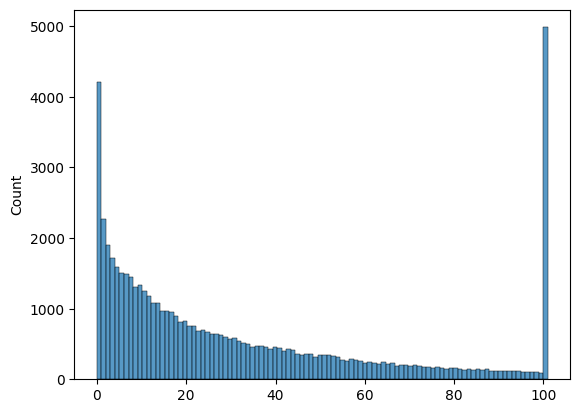

In [17]:
# Utterance length prior to turn shift in output (-1 does not occur in 10 tokens)
sns.histplot(data=first_token, bins=100)

In [7]:
ts.generate_indexes()[:10], ts.prefix_sum[:10]

([0, 14, 32, 56, 74, 97, 117, 137, 154, 175],
 [0, 14, 32, 56, 74, 97, 117, 137, 154, 175])

In [18]:
# Verify input/output of __getitem__ 
for idx in range(0,1000):
    print(f"idxs:{ts.get_dialog_idx(idx)},{idx} input: {ts.tokenizer.decode(ts[idx]['input']['input_ids'])}, output: {ts.tokenizer.decode(ts[idx]['output']['input_ids'])}")

idxs:(0, 0),0 input: , output: [CLS] okay now then you heard the question what what do you like to do for yourself in car automobile repairs [SEP] well i'll tell you i used to do a lot more repairs when cars were easy to work on than i do now [SEP] okay [SEP] i do uh i do the easy stuff now i i change oil uh and then what some people would consider a little more difficult i i'll change spark plugs and [SEP] um [SEP] i'll change you know points and you you know the air
idxs:(0, 50),1 input: okay [SEP], output: i do uh i do the easy stuff now i i change oil uh and then what some people would consider a little more difficult i i'll change spark plugs and [SEP] um [SEP] i'll change you know points and you you know the air filters that kind of stuff [SEP] well [SEP] but uh i can't do as much as i used to um i used to do a whole lot more but not anymore they're just too weird to work on now [SEP] is that the reason you '
idxs:(0, 100),2 input: um [SEP] i'll change you know points and you you

idxs:(21, 1700),504 input: oh jeez [SEP] rang the doorbell and mother came to the door and i wouldn't let her touch me i i wanted my brother to help me with this that was a shock the he put the phone down pretty quickly and it didn't take him long to extricate my hand but oh i was scared, output: to death i i i could see him cutting out my [SEP] that's hilarious [SEP] my whole palm just to get this little [SEP] to to get that jack off that's right [SEP] flap of skin out [SEP] oh that's a funny story [SEP] so that's that's how mechanical i am and that was oh that was twenty five years ago so i i've not tried it since [SEP] oh lord [SEP] oh plus plus before this i had put all the lugs back in place but
idxs:(21, 1750),505 input: oh that's a funny story [SEP], output: so that's that's how mechanical i am and that was oh that was twenty five years ago so i i've not tried it since [SEP] oh lord [SEP] oh plus plus before this i had put all the lugs back in place but i had the wrong side out 

idxs:(39, 0),967 input: , output: [CLS] well i haven't had an awful lot of uh incidents in regarding child care when my two year old was in new orleans she got bit on the cheek and uh but uh that's about the the uh the extent of it but but but the when i really am uh am concerned about is that uh so many of these child care places are are coming under uh uh you know investigation for for uh you know child molestation and i and i and i'm saying to myself well you know
idxs:(39, 50),968 input: well i haven't had an awful lot of uh incidents in regarding child care when my two year old was in new orleans she got bit on the cheek and uh but uh that's about the the uh the extent of it but but but, output: the when i really am uh am concerned about is that uh so many of these child care places are are coming under uh uh you know investigation for for uh you know child molestation and i and i and i'm saying to myself well you know you you dump your your your little turnip off to uh you know t

In [19]:
ts[30]['input'], ts.tokenizer.decode(ts[30]['input']['input_ids'])

({'input_ids': tensor([ 9616,   102,  8529,  2065,  1996,  5309,  2001,  2081,  2081,  5653,
           2344,  2027,  2323,  2031,  1037,  2501,  1997,  2073,  2009,  2001,
          12057,  2000,  1998,  2144,  2009,  2347,  1005,  1056, 12057,  2000,
           2014,  4769,  2016,  2071,  6011,  2017,  2113,  2008,  2009,  2347,
           1005,  1056,  2014,  8529,  2065,  2009,  2001,  2070,  2017,  2113,
           2746,  2046,  1996,  3573,  1998,  4933,  2059,  2016,  2052,  1997,
           2018,  9444,  2081,  1996,  5309,  2052,  2031,  2018,  3696,  2070,
           2785,  1997]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0